In [5]:
import altair as alt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [6]:
def start():
    options = {
        'display': {
            'max_columns': None,
            'max_colwidth': 25,
            'expand_frame_repr': False,  # Don't wrap to multiple pages
            'max_rows': 14,
            'max_seq_items': 50,         # Max length of printed sequence
            'precision': 4,
            'show_dimensions': False
        },
        'mode': {
            'chained_assignment': None   # Controls SettingWithCopyWarning
        }
    }

    for category, option in options.items():
        for op, value in option.items():
            pd.set_option(f'{category}.{op}', value)  # Python 3.6+

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

start()
del start

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [7]:
# https://github.com/rfordatascience/tidytuesday/tree/master/data/2019/2019-05-07
df = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-05-07/student_teacher_ratio.csv')
df

,edulit_ind,indicator,country_code,country,year,student_ratio,flag_codes,flags
0,PTRHC_2,Lower Secondary Educa...,MRT,Mauritania,2013,56.5939,NaN,NaN
1,PTRHC_2,Lower Secondary Educa...,MRT,Mauritania,2014,51.9469,NaN,NaN
2,PTRHC_2,Lower Secondary Educa...,MRT,Mauritania,2015,53.2272,NaN,NaN
3,PTRHC_2,Lower Secondary Educa...,MRT,Mauritania,2016,38.1892,NaN,NaN
4,PTRHC_1,Primary Education,COD,Democratic Republic o...,2012,34.7476,NaN,NaN
5,PTRHC_1,Primary Education,COD,Democratic Republic o...,2013,37.0692,NaN,NaN
6,PTRHC_1,Primary Education,COD,Democratic Republic o...,2014,35.3194,NaN,NaN
...,...,...,...,...,...,...,...,...
5182,PTRHC_3,Upper Secondary Educa...,COK,Cook Islands,2016,5.5140,NaN,NaN
5183,PTRHC_2,Lower Secondary Educa...,AZE,Azerbaijan,2016,6.9377,NaN,NaN


In [40]:
df.to_csv('./student_teacher_ratio.csv')

### Explore the Column Values

In [8]:
df['flag_codes'].value_counts(dropna=False)
df['flags'].value_counts(dropna=False)
df['year'].value_counts(dropna=False)
df['indicator'].value_counts(dropna=False)
df['country_code'].value_counts(dropna=False)

NaN    4185
‡       656
a       325
+        23
Name: flag_codes, dtype: int64

NaN                        4185
UIS Estimation              656
Category not applicable     325
National Estimation          23
Name: flags, dtype: int64

2015    921
2016    917
2014    913
2012    887
2013    880
2017    635
2018     36
Name: year, dtype: int64

Primary Education                        1029
Secondary Education                       840
Pre-Primary Education                     837
Lower Secondary Education                 739
Upper Secondary Education                 700
Tertiary Education                        550
Post-Secondary Non-Tertiary Education     494
Name: indicator, dtype: int64

UZB    42
MAC    42
VAT    42
AUT    42
GHA    40
BHR    39
MDA    39
       ..
SMR     3
MHL     2
PLW     2
FSM     2
IRL     1
TKM     1
NGA     1
Name: country_code, dtype: int64

In [52]:
def filter_df_by_indicator_year(df, indicator, year=None):
    if year:
        _filter = (df['indicator'] == indicator) & (df['year'] == year)
    else:
        _filter = (df['indicator'] == indicator)

    _df = (
        df[_filter][['country', 'country_code', 'student_ratio']][~df['student_ratio'].isnull()]
         .sort_values('student_ratio')
    )
    return _df

In [11]:
_df = filter_df_by_indicator_year(df, 'Primary Education', year=2015)
_sliced_df = pd.concat([_df.head(10), _df.tail(10)])

/Users/rsharr200/dev/notebooks3/env/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


### Histogram Plot of Student Ratio

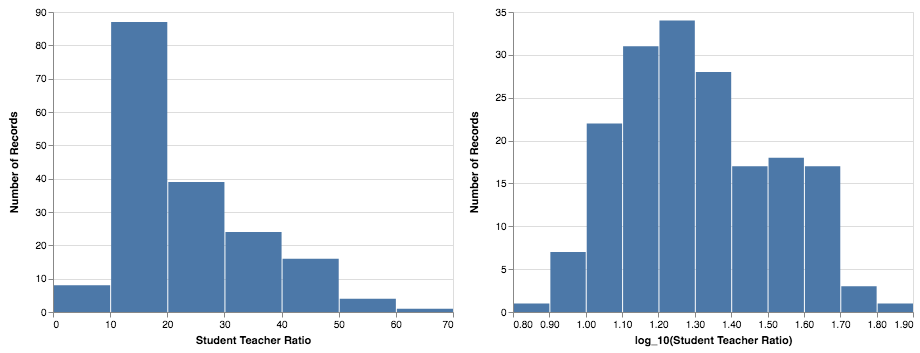

In [14]:
chart = alt.Chart(_df).mark_bar().encode(
    x=alt.X("student_ratio:Q", title='Student Teacher Ratio', bin=True),
    y='count()'
)

chart_log = alt.Chart(_df).transform_calculate(
    log_student_ratio = 'log(datum.student_ratio)/log(10)'
).mark_bar().encode(
    x=alt.X('log_student_ratio:Q', bin=True, title='log_10(Student Teacher Ratio)'),
    y='count()'
)

chart | chart_log

### Bar Plot of Highest and Lowest Student Teacher Ratios

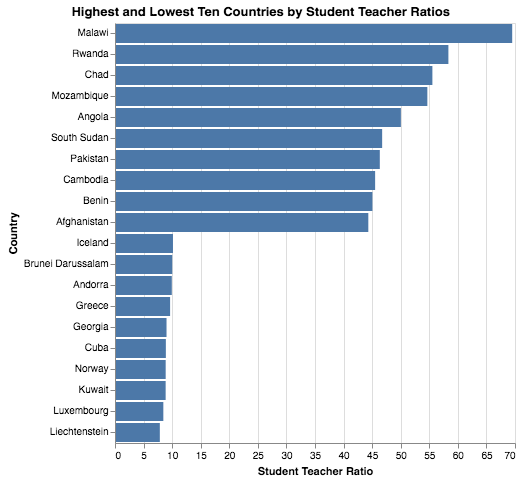

In [15]:
chart = alt.Chart(_sliced_df).mark_bar().encode(
    x=alt.X("student_ratio:Q", title='Student Teacher Ratio'),
    y=alt.Y(
        'country:N',
        sort=alt.EncodingSortField(
            field="student_ratio",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        ),
        title='Country'
    )
).properties(
    title='Highest and Lowest Ten Countries by Student Teacher Ratios'
)

chart

### Adding in WDI Data

In [16]:
wdi_df = pd.read_csv('../WDI_csv/WDIData.csv')

In [17]:
def filter_wdi_by_indicator_year(df, indicator, year=None):
    _filter = df['Indicator Code'] == indicator
    
    if not year:
        return df[_filter]

    return df[_filter][['Country Code', str(year)]]

In [31]:
# NY.GDP.PCAP.CD - GDP per capita in US$
gdp_2015_df = filter_wdi_by_indicator_year(wdi_df, 'NY.GDP.PCAP.CD', 2015)
merged_df = pd.merge(_df, gdp_2015_df, left_on=['country_code'], right_on=['Country Code'])
merged_df

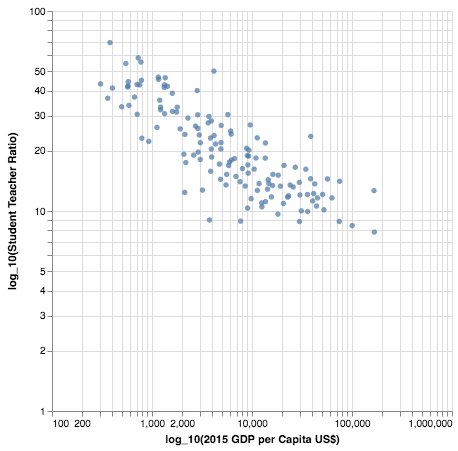

In [34]:
chart_log = alt.Chart(merged_df).mark_circle().encode(
    x=alt.X('2015:Q', scale=alt.Scale(type='log', base=10), title='log_10(2015 GDP per Capita US$)'),
    y=alt.Y('student_ratio:Q', scale=alt.Scale(type='log', base=10), title='log_10(Student Teacher Ratio)'),
    tooltip=['country', 'country_code', 'student_ratio', '2015']
)

chart_log.properties(height=400, width=400)

#### Results
- GDP per Capita and Student Teacher Ratio are negatively correlated

In [35]:
# SP.POP.TOTL - Total Population
pop_2015_df = filter_wdi_by_indicator_year(wdi_df, 'SP.POP.TOTL', year='2015')
pop_2015_df

,Country Code,2015
1142,ARB,3.9603e+08
2741,CSS,7.2222e+06
4340,CEB,1.0326e+08
5939,EAR,3.1228e+09
7538,EAS,2.2829e+09
9137,EAP,2.0382e+09
10736,TEA,2.0130e+09
...,...,...
412085,VEN,3.0082e+07
413684,VNM,9.2677e+07


In [36]:
pop_merged_df = pd.merge(merged_df, pop_2015_df, on=['Country Code'], suffixes=('_gdp', '_population'))
pop_merged_df

,country,country_code,student_ratio,Country Code,2015_gdp,2015_population
0,Liechtenstein,LIE,7.8452,LIE,167290.9400,3.7470e+04
1,Luxembourg,LUX,8.4577,LUX,100428.3680,5.6960e+05
2,Kuwait,KWT,8.8623,KWT,29869.5294,3.8356e+06
3,Norway,NOR,8.8686,NOR,74521.5699,5.1886e+06
4,Cuba,CUB,8.8992,CUB,7694.0119,1.1325e+07
5,Georgia,GEO,9.0166,GEO,3756.3838,3.7253e+06
6,Greece,GRC,9.6436,GRC,18167.7737,1.0821e+07
...,...,...,...,...,...,...
135,Pakistan,PAK,46.3406,PAK,1356.6677,1.9943e+08
136,South Sudan,SSD,46.7503,SSD,1154.8009,1.0716e+07


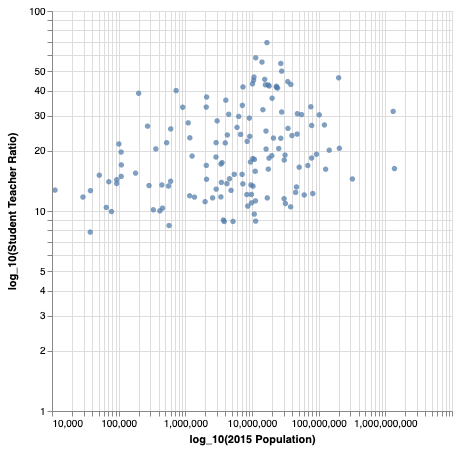

In [135]:
# Not sure if I should use log scale here

chart_log_pop = alt.Chart(pop_merged_df).mark_circle().encode(
    x=alt.X('2015_population:Q', scale=alt.Scale(type='log', base=10), title='log_10(2015 Population)'),
    y=alt.Y('student_ratio:Q', scale=alt.Scale(type='log', base=10), title='log_10(Student Teacher Ratio)'),
    tooltip=['country', 'country_code', 'student_ratio', '2015_population']
)

chart_log_pop.properties(height=400, width=400)

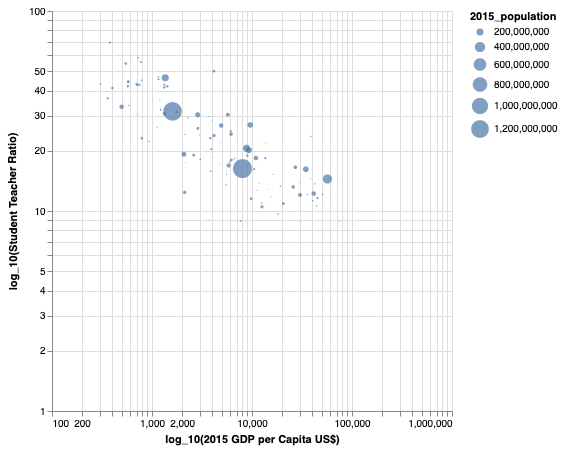

In [139]:
chart_log = alt.Chart(pop_merged_df).mark_circle().encode(
    x=alt.X('2015_gdp:Q', scale=alt.Scale(type='log', base=10), title='log_10(2015 GDP per Capita US$)'),
    y=alt.Y('student_ratio:Q', scale=alt.Scale(type='log', base=10), title='log_10(Student Teacher Ratio)'),
    size='2015_population:Q',
    tooltip=['country', 'country_code', 'student_ratio', '2015_gdp', '2015_population']
).interactive()

chart_log.properties(height=400, width=400)

In [37]:
# Region data
wdi_country_df = pd.read_csv('../WDI_csv/WDICountry.csv')

In [38]:
def add_region_to_wdi(df, wdi_country_df):
    return pd.merge(df, wdi_country_df[['Country Code', 'Region']], on=['Country Code'])

In [39]:
pop_reg_merged_df = add_region_to_wdi(pop_merged_df, wdi_country_df)
pop_reg_merged_df

,country,country_code,student_ratio,Country Code,2015_gdp,2015_population,Region
0,Liechtenstein,LIE,7.8452,LIE,167290.9400,3.7470e+04,Europe & Central Asia
1,Luxembourg,LUX,8.4577,LUX,100428.3680,5.6960e+05,Europe & Central Asia
2,Kuwait,KWT,8.8623,KWT,29869.5294,3.8356e+06,Middle East & North A...
3,Norway,NOR,8.8686,NOR,74521.5699,5.1886e+06,Europe & Central Asia
4,Cuba,CUB,8.8992,CUB,7694.0119,1.1325e+07,Latin America & Carib...
5,Georgia,GEO,9.0166,GEO,3756.3838,3.7253e+06,Europe & Central Asia
6,Greece,GRC,9.6436,GRC,18167.7737,1.0821e+07,Europe & Central Asia
...,...,...,...,...,...,...,...
135,Pakistan,PAK,46.3406,PAK,1356.6677,1.9943e+08,South Asia
136,South Sudan,SSD,46.7503,SSD,1154.8009,1.0716e+07,Sub-Saharan Africa


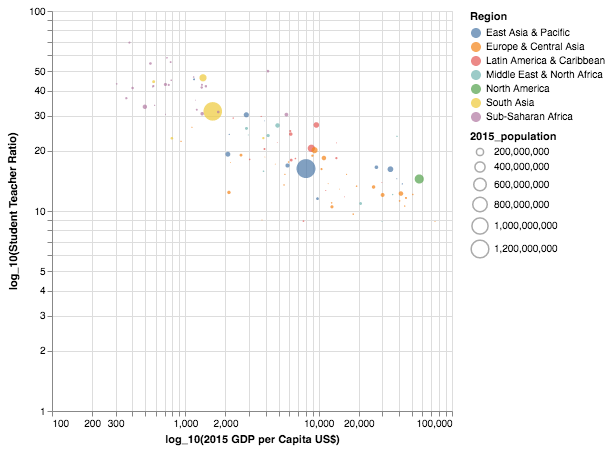

In [45]:
large_df = pop_reg_merged_df.sort_values('2015_population', ascending=False)[:100]

chart_log = alt.Chart(large_df).mark_circle().encode(
    x=alt.X('2015_gdp:Q', scale=alt.Scale(type='log', base=10), title='log_10(2015 GDP per Capita US$)'),
    y=alt.Y('student_ratio:Q', scale=alt.Scale(type='log', base=10), title='log_10(Student Teacher Ratio)'),
    size='2015_population:Q',
    color='Region:N',
    tooltip=['country', 'country_code', 'Region', 'student_ratio', '2015_gdp', '2015_population']
).interactive()

chart_log.properties(height=400, width=400)

In [53]:
# Primary vs Secondary S/T Ratios

secondary_df = filter_df_by_indicator_year(df, 'Secondary Education', year=2015)

secondary_merged_df = pd.merge(secondary_df, gdp_2015_df, left_on=['country_code'], right_on=['Country Code'])
pop_secondary_merged_df = pd.merge(secondary_merged_df, pop_2015_df, on=['Country Code'], suffixes=('_gdp', '_population'))
pop_reg_secondary_merged_df = pd.merge(pop_secondary_merged_df, wdi_country_df[['Country Code', 'Region']], on=['Country Code'])
pop_reg_secondary_merged_df

/Users/rsharr200/dev/notebooks3/env/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,country,country_code,student_ratio,Country Code,2015_gdp,2015_population,Region
0,Tuvalu,TUV,6.1675,TUV,3197.7956,1.1099e+04,East Asia & Pacific
1,Bermuda,BMU,6.3323,BMU,NaN,6.5239e+04,North America
2,Ukraine,UKR,6.9702,UKR,2124.6627,4.5154e+07,Europe & Central Asia
3,Croatia,HRV,7.0333,HRV,11780.1312,4.2036e+06,Europe & Central Asia
4,Georgia,GEO,7.2471,GEO,3756.3838,3.7253e+06,Europe & Central Asia
5,Kazakhstan,KAZ,7.5067,KAZ,10510.7719,1.7543e+07,Europe & Central Asia
6,Kuwait,KWT,7.5884,KWT,29869.5294,3.8356e+06,Middle East & North A...
...,...,...,...,...,...,...,...
107,India,IND,31.6502,IND,1605.6054,1.3102e+09,South Asia
108,Mauritania,MRT,33.5468,MRT,1194.3125,4.0463e+06,Sub-Saharan Africa


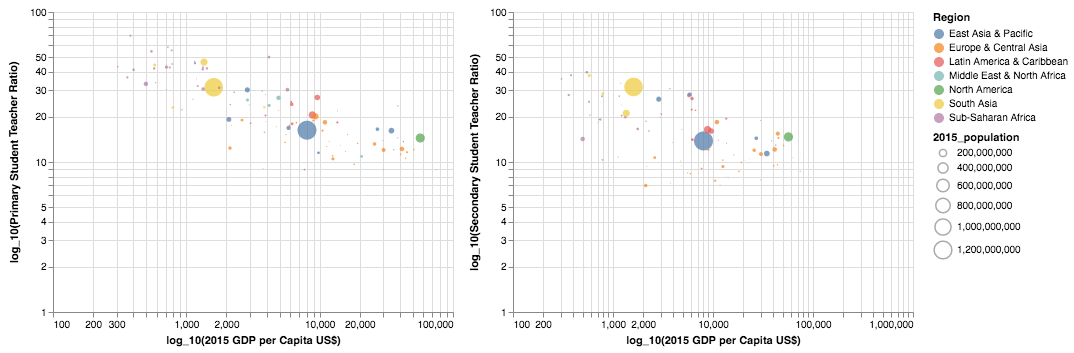

In [54]:
chart_log = alt.Chart(large_df).mark_circle().encode(
    x=alt.X('2015_gdp:Q', scale=alt.Scale(type='log', base=10), title='log_10(2015 GDP per Capita US$)'),
    y=alt.Y('student_ratio:Q', scale=alt.Scale(type='log', base=10), title='log_10(Primary Student Teacher Ratio)'),
    size='2015_population:Q',
    color='Region:N',
    tooltip=['country', 'country_code', 'Region', 'student_ratio', '2015_gdp', '2015_population']
).interactive()

secondary_large_df = pop_reg_secondary_merged_df.sort_values('2015_population', ascending=False)[:100]

secondary_chart_log = alt.Chart(secondary_large_df).mark_circle().encode(
    x=alt.X('2015_gdp:Q', scale=alt.Scale(type='log', base=10), title='log_10(2015 GDP per Capita US$)'),
    y=alt.Y('student_ratio:Q', scale=alt.Scale(type='log', base=10), title='log_10(Secondary Student Teacher Ratio)'),
    size='2015_population:Q',
    color='Region:N',
    tooltip=['country', 'country_code', 'Region', 'student_ratio', '2015_gdp', '2015_population']
).interactive()

chart_log | secondary_chart_log

#### Secondary School Student Teacher Ratio does not have as strong a negative correlation as primary school education.